# Discovering Market Trends in Video Game Sales

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
from sklearn.cluster import KMeans

import warnings

warnings.filterwarnings('ignore')

In [47]:
# Load the dataset
data = pd.read_csv('./Online_game.csv')

# Display the first few rows and summary information
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


(   Rank                      Name Platform    Year         Genre Publisher  \
 0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
 1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
 2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
 3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
 4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   
 
    NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
 0     41.49     29.02      3.77         8.46         82.74  
 1     29.08      3.58      6.81         0.77         40.24  
 2     15.85     12.88      3.79         3.31         35.82  
 3     15.75     11.01      3.28         2.96         33.00  
 4     11.27      8.89     10.22         1.00         31.37  ,
 None)

### Problem Description

The goal is to analyze patterns and similarities in video game sales across different regions (NA, EU, JP, and Other) using unsupervised learning techniques. By clustering games based on their sales data, genre, platform, and release year, we aim to uncover distinct market trends and groupings. This can reveal insights into how different game characteristics impact sales performance across various geographic markets, highlight popular genres and platforms, and identify factors influencing global success. The findings could benefit game developers and marketers in designing and positioning games for optimal reach and profitability across regions.

The data was obtained from __[https://www.kaggle.com/datasets/nayanack/online-game-dataset](https://www.kaggle.com/datasets/nayanack/online-game-dataset)__

### Exploratory Data Analysis

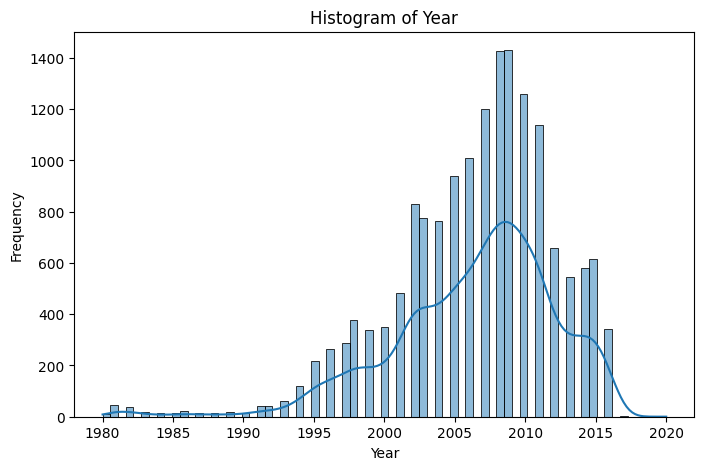

In [48]:
# List of numerical and categorical columns
numerical_columns = ['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
categorical_columns = ['Platform', 'Genre']

plt.figure(figsize=(8, 5))
sns.histplot(data['Year'].dropna(), kde=True)
plt.title('Histogram of Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

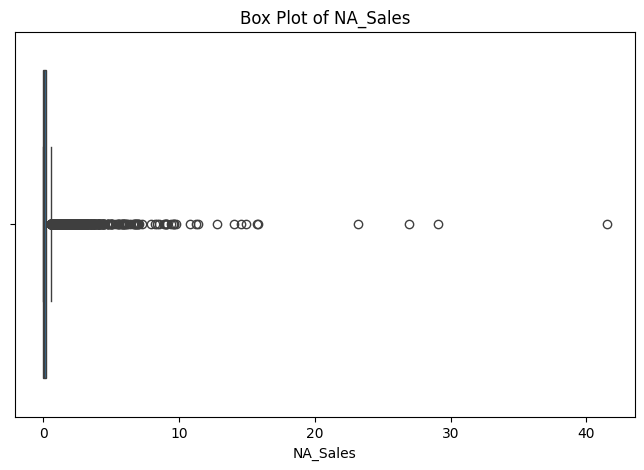

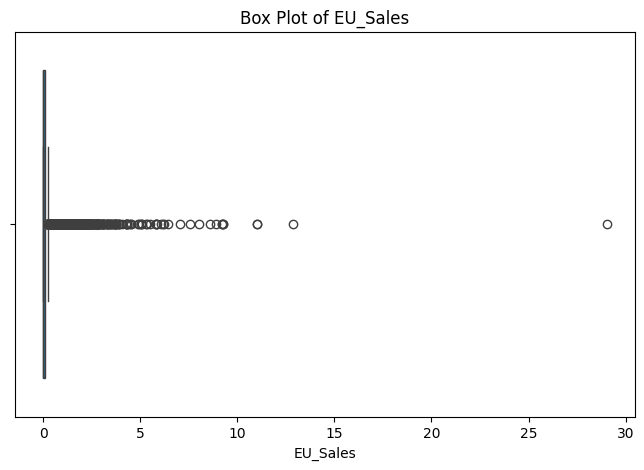

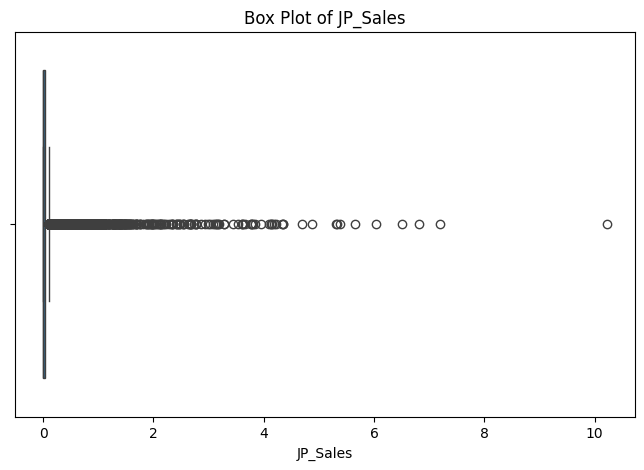

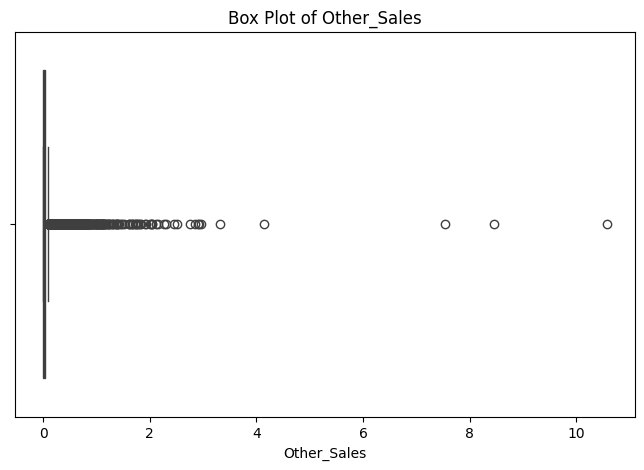

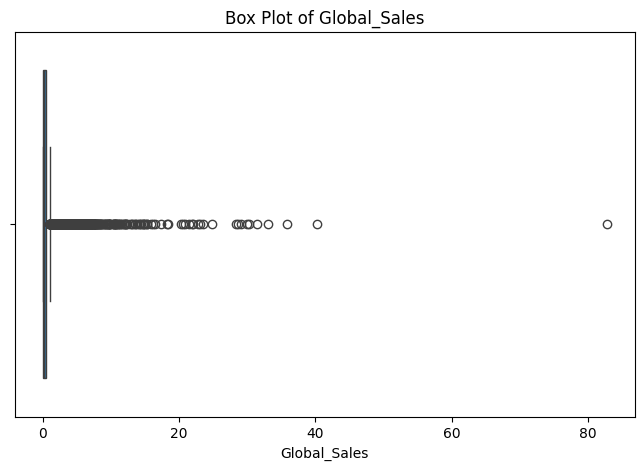

In [6]:
# Plotting box plots
for column in numerical_columns[1:]:  # Excluding 'Year' as it isn't typical for boxplots
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data[column].dropna())
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

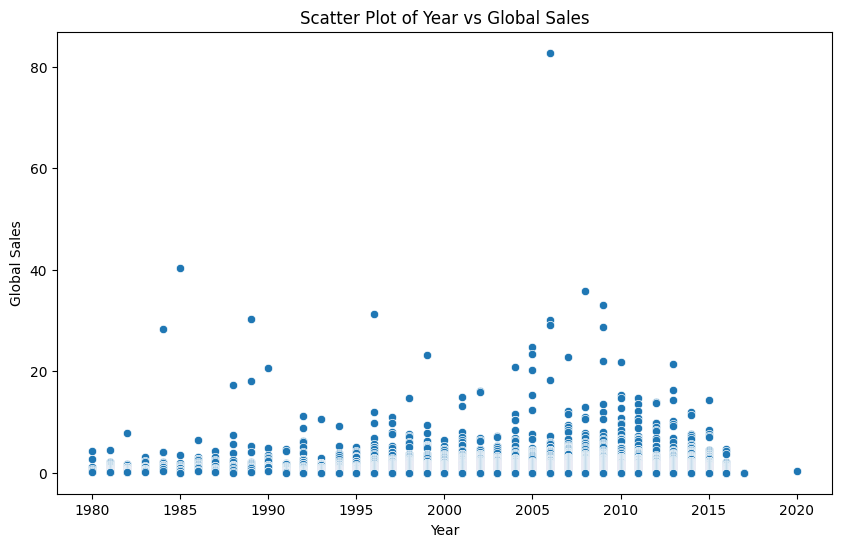

In [7]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Global_Sales', data=data)
plt.title('Scatter Plot of Year vs Global Sales')
plt.xlabel('Year')
plt.ylabel('Global Sales')
plt.show()

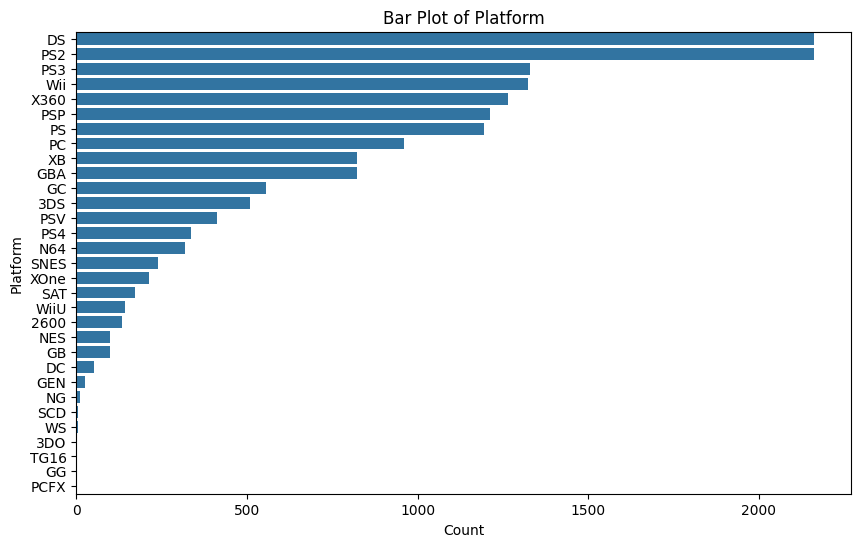

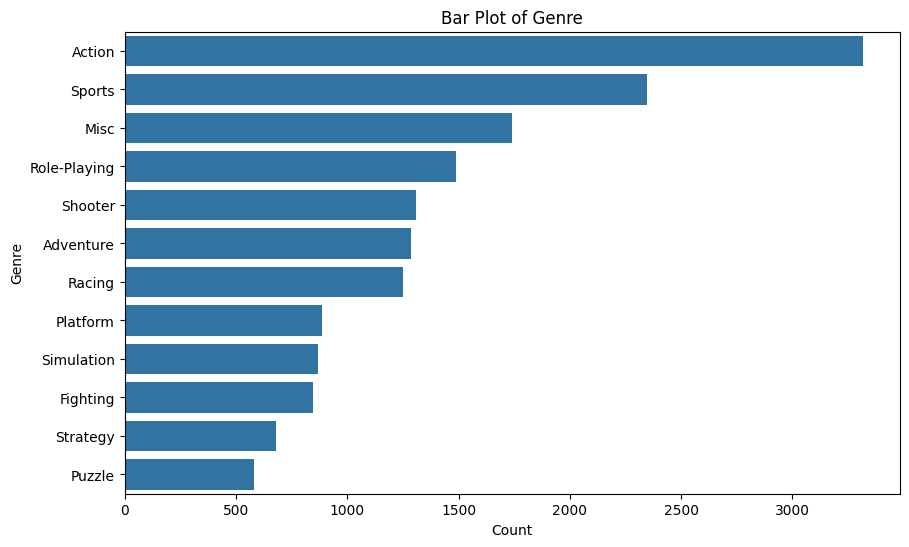

In [9]:
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=data[column], order=data[column].value_counts().index)
    plt.title(f'Bar Plot of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()

**Numerical Features**
- Year: The histogram shows the distribution of release years, highlighting trends over time.

**Scatter Plot (Year vs. Global Sales)**
- The scatter plot indicates potential trends in global sales over time, which could suggest periods of higher or lower overall sales in the gaming market.

**Categorical Features**
- Platform: The bar plot displays the count of games on each platform, showing the popularity of certain platforms in the dataset.
- Genre: The bar plot for genres shows the distribution across different game types.

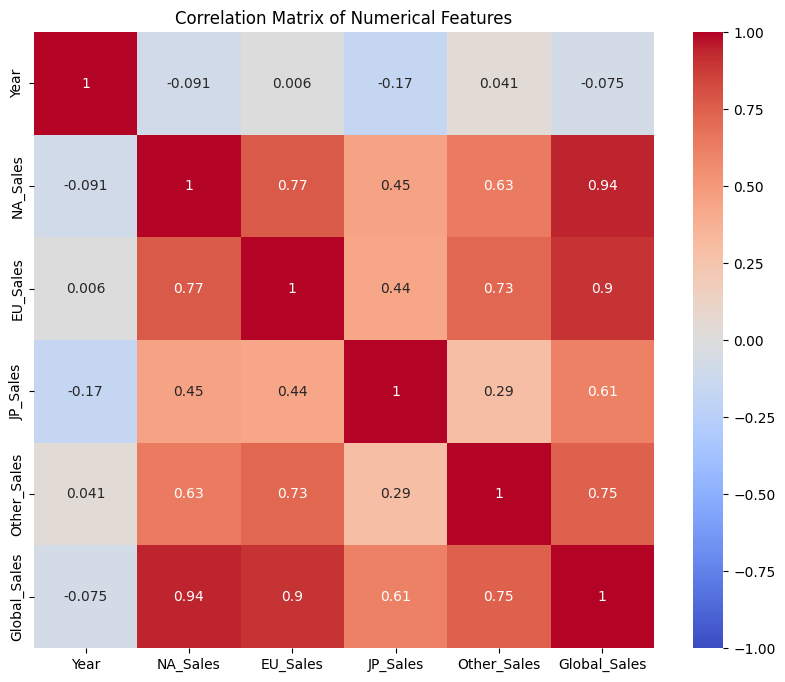

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Year,1.000000,-0.091402,0.006014,-0.169316,0.041058,-0.074735
NA_Sales,-0.091402,1.000000,0.767727,0.449787,0.634737,0.941047
EU_Sales,0.006014,0.767727,1.000000,0.435584,0.726385,0.902836
JP_Sales,-0.169316,0.449787,0.435584,1.000000,0.290186,0.611816
Other_Sales,0.041058,0.634737,0.726385,0.290186,1.000000,0.748331
Global_Sales,-0.074735,0.941047,0.902836,0.611816,0.748331,1.000000


In [10]:
# Checking for correlations among numerical features
correlation_matrix = data[numerical_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Displaying correlation values
correlation_matrix


**Sales Across Regions**
- NA_Sales, EU_Sales, JP_Sales, Other_Sales, and Global_Sales show strong positive correlations, especially NA_Sales with Global_Sales (correlation of 0.94) and EU_Sales with Global_Sales (correlation of 0.90). This indicates that games successful in one region are often successful globally.
- The moderate correlation between JP_Sales and other sales regions (ex: NA_Sales with a 0.45 correlation) suggests a slight divergence in consumer preferences in Japan compared to other markets.

**Year**
- The Year feature has weak correlations with the sales columns, suggesting that while release year has some influence on sales trends, it is not a strong predictor of success.

### Missing Values/Outliers

In [49]:
# Checking for missing values and summarizing them
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Only display columns with missing values

# Checking for outliers in numerical columns
outlier_summary = {}

for column in numerical_columns:
    # Using the IQR method to detect outliers
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR))).sum()
    outlier_summary[column] = outliers

missing_values, outlier_summary

(Year         271
 Publisher     58
 dtype: int64,
 {'Year': 305,
  'NA_Sales': 1681,
  'EU_Sales': 2081,
  'JP_Sales': 2425,
  'Other_Sales': 1665,
  'Global_Sales': 1893})

### Data Transformations

In [50]:
# Handle missing values
data['Year'].fillna(data['Year'].median(), inplace=True)
data['Publisher'].fillna("Unknown", inplace=True)

# Apply log transformation to the sales columns
for column in numerical_columns[1:]:  # Only sales columns
    data[column] = np.log1p(data[column])

# Scale numerical features
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Label encoding for categorical features
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

- Missing values in Year were imputed with the median, and missing Publisher values were filled with "Unknown."
- Since the outliers likely represent games with very high sales, they are meaningful data points and shouldn't be removed. They will remain in the dataset for modeling.
  
The following transformations were applied:

- Log Transformation: Applied to the sales columns (NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales) to reduce skewness and handle outliers.
- Scaling: Standard scaling was applied to all numerical features, including the transformed sales columns and Year.
- Label Encoding: Applied to Platform and Genre.

### Model Analysis - KMeans Clustering

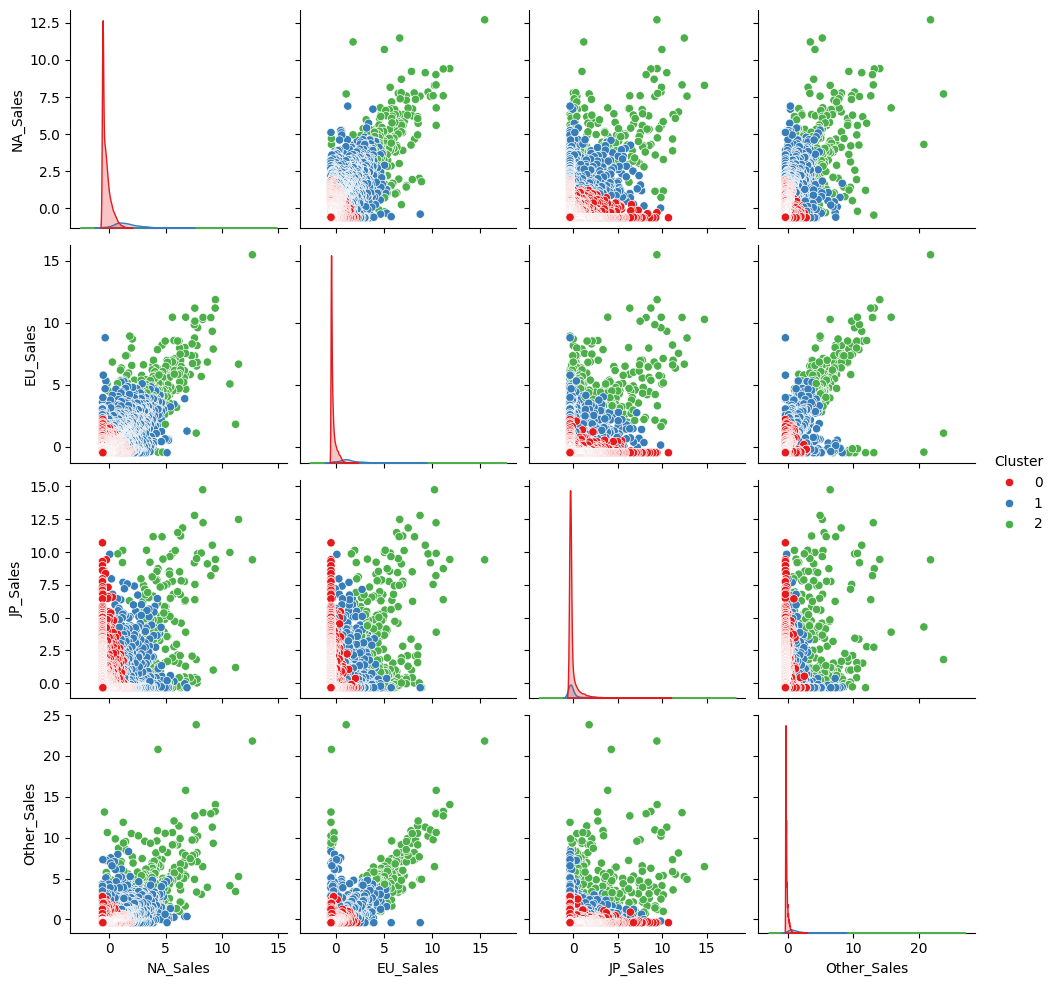

In [38]:
# Selecting features for clustering
X = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # 3 clusters
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters using a pairplot
sns.pairplot(data, vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], hue='Cluster', palette='Set1')
plt.show()

### Model Analysis - KMeans Clustering With PCA

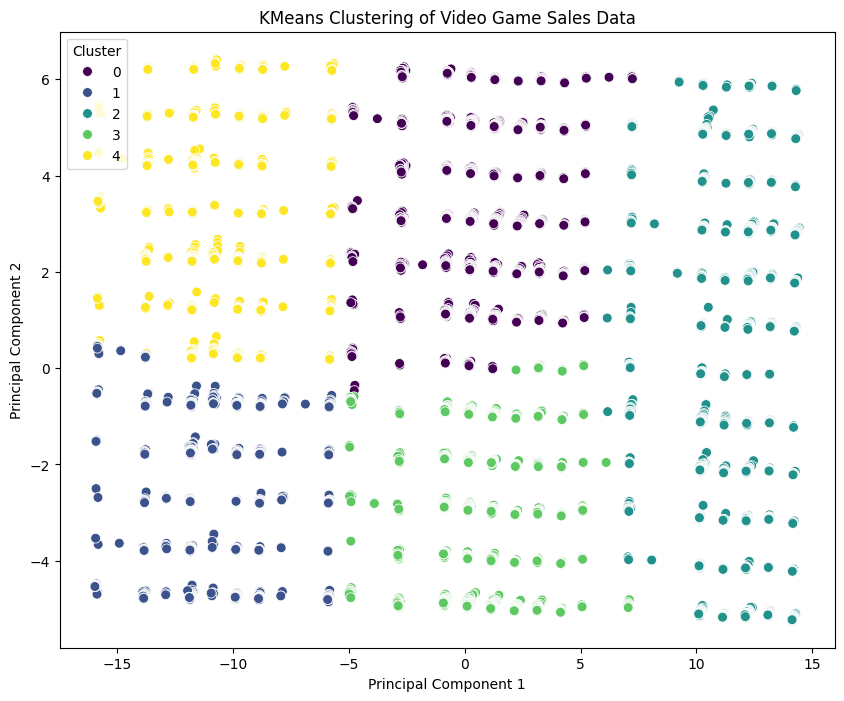

In [36]:
# Reduce dimensionality with PCA
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data[numerical_columns + categorical_columns])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_reduced)

# Adding cluster labels to the reduced data
data_reduced_with_clusters = pd.DataFrame(data_reduced, columns=['PC1', 'PC2'])
data_reduced_with_clusters['Cluster'] = clusters

# Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data_reduced_with_clusters, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=50)
plt.title('KMeans Clustering of Video Game Sales Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### Result

This graph shows the result of applying the K-Means Clustering technique on the data set. The clusters are decently separated in the plot, suggesting that the K-Means algorithm effectively distinguished different sales patterns. Each video game in the dataset is assigned to one of the clusters based on its sales across different regions (North America, Europe, Japan, and Other regions.)
The Cluster column added to the data frame indicates the cluster each game belongs to (0, 1 and 2 in this case.)


In [41]:
# Check the cluster centers (in the scaled feature space)
print("Cluster centers:\n", kmeans.cluster_centers_)

# The number of games in each cluster
print(data['Cluster'].value_counts())

Cluster centers:
 [[-0.30297245 -0.2937336  -0.09026686 -0.25281396]
 [ 1.47256256  1.31320301  0.19381846  1.00177331]
 [ 4.21031464  5.00055587  3.22011317  5.33520426]]
Cluster
0    14176
1     2154
2      268
Name: count, dtype: int64


The cluster centers show the coordinates of the centroids in the scaled feature space. These represent the "average" sales values of the games in each cluster.
The cluster size will show how many games fall into each cluster. If one cluster has significantly more games than others, it might indicate that this group represents the most common sales pattern among video games.
Based on this graph, games in cluster 0 have lower sales than games in cluster 1 or 2. Since the majority of games are in cluster 0, it can be inferred that a small amount of games have higher than average sales. 

In [44]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scaled, data['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.4f}')

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X_scaled, data['Cluster'])
print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')

Silhouette Score: 0.6366
Davies-Bouldin Index: 0.9714


- Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters. Values range from -1 to 1, where 1 indicates well-separated clusters. This value is closer to 1 which indicates that the clusters are decently separated.
- Davies-Bouldin Index: Measures the average "similarity ratio" of each cluster with its most similar cluster. Lower values indicate better clustering. This value is relatively low, indicating decent clustering performance.

### Conclusion

In this analysis, we explored the video game sales dataset using unsupervised machine learning techniques to uncover patterns and insights. After cleaning and transforming the data to handle missing values, scaling numerical features, and encoding categorical variables, we used KMeans clustering to group similar games based on sales performance, release year, genre, platform, and publisher. We also applied Principal Component Analysis (PCA) for dimensionality reduction. 

The clustering results provided a high-level overview of distinct game groupings, which could reflect differences in consumer preferences, market reach, or genre popularity. Each cluster represents a unique combination of factors, offering valuable insights for stakeholders in the gaming industry, such as identifying successful genre-platform combinations or uncovering region-specific trends.